# Classifier

## Import packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from time import time
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score, classification_report, precision_recall_curve, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
df = pd.read_pickle("allfeat_df_allcomments.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Columns: 18201 entries, ('text', 'body') to ('lda', 'ldahundred')
dtypes: float64(2091), int64(16103), object(7)
memory usage: 223.0+ MB


In [4]:
# predictors = df.columns
# i = 0
# predictorsfile=open('featurelist.txt','w')
# # predictorsfile.writelines(predictors)
# for index in range(len(predictors)):
#     predictorsfile.write(str(i))
#     predictorsfile.write(predictors[index][0])
#     predictorsfile.write(" ")
#     predictorsfile.write(predictors[index][1])
#     predictorsfile.write('\n')
#     i+=1
# predictorsfile.close()

In [5]:
# df = df.dropna(axis=0, how='all')
# df = df.dropna(axis=1, how='all')

In [8]:
# level 0 column names
predictors = df.columns
featurelst = []
for i in range(len(predictors)):
    featurelst.append(predictors[i][0])
featureset = set(featurelst)
print(featureset)

{'post', 'x_feat', 'lda', 'ngram', 'psych', 'empath', 'trait', 'data', 'subreddit', 'time', 'text', 'lin_feat'}


In [9]:
# create smaller dfs
log_wordngrams_df = df[['trait', 'ngram']]
log_charngrams_df = df[['trait', 'ngram']]
log_wordlists_df =  df[['trait', 'x_feat', 'lin_feat', 'psych', 'empath']]
log_posts_df = df[['trait', 'post', 'time', 'subreddit', 'lda']]
log_postswithoutsubreddits_df = df[['trait', 'post', 'time', 'lda']]

In [10]:
# separate word ngrams
droplst = []
index = 17124
for i in range(1000):
    index = index+1
    droplst.append(predictors[index][1])

log_wordngrams_df = log_wordngrams_df.drop(droplst, axis=1, level=1)

In [11]:
# separate char ngrams
worddroplst = []
wordindex = 16125
for i in range(1000):
    wordindex = wordindex+1
    worddroplst.append(predictors[wordindex][1])

log_charngrams_df = log_charngrams_df.drop(worddroplst, axis=1, level=1)

In [12]:
def all_hist_true(df):
    plt.figure(figsize = (16, 16))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(3, 2, 1)
    plt.hist(df['trait', 'openness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(3, 2, 2)
    plt.hist(df['trait', 'conscientiousness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(3, 2, 3)
    plt.hist(df['trait', 'extraversion'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(3, 2, 4)
    plt.hist(df['trait', 'agreeableness'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(3, 2, 5)
    plt.hist(df['trait', 'neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()

## Trait

In [3]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, classes, trait_name):
    featuredf = df.drop(['data', 'trait', 'text'], axis=1, level=0)
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols] 
    
    if classes=='binary':
    
        if trait_name == 'agreeableness':
            y = df['trait', 'big5_o']
        elif trait_name == 'openness':
            y = df['trait', 'big5_c']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'big5_e']
        elif trait_name == 'extraversion':
            y = df['trait', 'big5_a']
        elif trait_name == 'neuroticism':
            y = df['trait', 'big5_n']   
    elif classes=='multi':
        if trait_name == 'agreeableness':
            y = df['trait', 'big5_o_multi']
        elif trait_name == 'openness':
            y = df['trait', 'big5_c_multi']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'big5_e_multi']
        elif trait_name == 'extraversion':
            y = df['trait', 'big5_a_multi']
        elif trait_name == 'neuroticism':
            y = df['trait', 'big5_n_multi'] 
    elif classes=='linear':
        if trait_name == 'agreeableness':
            y = df['trait', 'agreeableness']
        elif trait_name == 'openness':
            y = df['trait', 'openness']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'conscientiousness']
        elif trait_name == 'extraversion':
            y = df['trait', 'extraversion']
        elif trait_name == 'neuroticism':
            y = df['trait', 'neuroticism']  
    return x,y 

## Classifier

## Get names of 30 most important features

In [4]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names
# names = get_names(logpipe)
# print(names)

### Get p-values

In [5]:
def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

## Scores

In [6]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()
    
    return lr_precision, lr_recall

### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [7]:
def create_cnfmatrix(clf, x_test, y_test, y_pred, plotting, detailed):
    cnfpipe_matrix = confusion_matrix(y_test, y_pred)

    if detailed:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sumpositive = tp + fn
        sumnegative = fp + tn
        sumcorrect = tp + tn
        sumwrong = fp + fn
        sumall = tn+fp+fn+tp
        print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
              sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
              sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
              "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)

    if plotting:
        plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()


## ROC Curve

In [8]:
def roc_aucscore(clf, x_test, y_test, classes, plotting, detailed):
    if detailed:
        print(roc_auc_score(y, clf.predict_proba(x), multi_class='ovo'))
        return score
    
    if plotting and classes == 'binary':
        plot_roc_curve(clf, x_test, y_test)
        plt.title('ROC Curve', y=1.1)
        plt.show()

In [9]:
traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

def switching(trait):
    switcher={
            'openness':30,
            'conscientiousness': 30,
            'agreeableness': 30,
            'extraversion': 30,
            'neuroticism':30
         }
    return switcher.get(trait,"Invalid")

## Wrapper with nested stratified cross validation

In [14]:
def get_classifier(classifier):
    if classifier == 'log':
        return LogisticRegression(class_weight='balanced', n_jobs=-1)
    elif classifier == 'mcc':
        return DummyClassifier(strategy="most_frequent")
    elif classifier == 'mlp':
        return MLPClassifier()
    elif classifier == 'svm':
        return svm.SVC(class_weight='balanced', probability=True)
    elif classifier == 'linear':
        return LinearRegression(n_jobs=-1)
    elif classifier == 'multilog':
        return LogisticRegression(multi_class='multinomial', n_jobs=-1)
    elif classifier == 'knn':
        return KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    
def get_featureselection(fs, classifier, X, y):
    if fs == 'anova':
        return SelectKBest(f_classif, k=30)
    if fs == 'mutual':
        return mutual_info_classif(X, y)
    if fs == 'sequential_forward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=30, direction='forward', n_jobs=-1)
    if fs == 'sequential_backward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=30, direction='backward', n_jobs=-1)


    
def create_pipeline_cv(classifier, fs, dim, X, y):
    if dim:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('pca', PCA(n_components=100)),
              ('feature_selection',  get_featureselection(fs, classifier, X, y)),
              ('classification', get_classifier(classifier))
            ])
    else:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  get_featureselection(fs, classifier, X, y)),
              ('classification', get_classifier(classifier))
            ])
    return pipeline

In [15]:
def get_params(classifier):
    if classifier == 'log':
        params = {'classification__solver': ['lbfgs', 'liblinear', 'saga'], 
                  'classification__max_iter': [100, 200, 500, 1000],
                  'classification__C': [10**x for x in range(-3,5)]}
    if classifier == 'multilog':
        params = {'classification__class_weight': [None, 'balanced'], 
                  'classification__solver': ['lbfgs', 'saga'], 
                  'classification__max_iter': [100, 200, 500, 1000]}
    elif classifier == 'mlp':
        params = {'classification__hidden_layer_sizes': [(50,), (100,), (200,), (500,)]}
    elif classifier == 'svm':
        params = {'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'classification__gamma': ['scale', 'auto'], 
                  'classification__max_iter': [100, 200, 500, 1000],
                  'classification__C': [10**x for x in range(-3,5)]}
    elif classifier == 'mcc':
        params = {}
    return params

def classify_cv(df, classes, clf_lst, fs, dim):
    for option in tqdm(clf_lst):
        print("Classifier: ", option, "\n")
        for trait_name in tqdm(traits):
            num_feat = switching(trait_name)
            print("\nTrait to predict: ", trait_name, "\n")
            x,y = trait(df, classes, trait_name)          
            
            cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
            cv_outer_lst = cv_outer.split(x, y)

            f1macro_lst = []
            for train_idx, val_idx in tqdm(cv_outer_lst):
                train_data, val_data = x.iloc[train_idx], x.iloc[val_idx]
                train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]

                print("\n\tCreate pipeline with", option, "...")
                clf = create_pipeline_cv(option, fs, dim, train_data, train_target)
                if option == 'log':
                    cv_inner = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
                if option == 'svm' or option == 'mlp' or option == 'mcc':
                    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
                params = get_params(option)
                print("\tStart grid search...")
                t0 = time()
                gd_search = GridSearchCV(clf, params, scoring='f1_macro', n_jobs=-1, cv=cv_inner).fit(train_data, train_target)
                print("\tGrid search done in %0.3fs" % (time() - t0))
                print("\tGet best model...")
                best_model = gd_search.best_estimator_
                print(best_model)

                print("\tFit best model...")
                clfnew = best_model.fit(train_data, train_target)
                y_pred = clfnew.predict(val_data)
                f1_macro = f1_score(val_target, y_pred, average='macro')
                f1macro_lst.append(f1_macro)
                print("Val Acc:",f1_macro , "Best GS Acc:",gd_search.best_score_, "Best Params:",gd_search.best_params_)

              # Training final model
            f1macro_avg = np.mean(f1macro_lst)
            print("Average f1 macro score: ", f1macro_avg)


## Methodological replication

In [22]:
clf_lst = ['mcc', 'log', 'mlp', 'svm']
classify_cv(df, 'binary', clf_lst, 'anova', dim=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Classifier:  mcc 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 4.567s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.3831417624521073 Best GS Acc: 0.3829883396341315 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 3.187s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.38269230769230766 Best GS Acc: 0.3831004427227449 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 3.084s
	Get best model...
Pipeline(steps=[('v

0it [00:00, ?it/s]


	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.567s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.39245283018867927 Best GS Acc: 0.39233278864349774 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.605s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.39204545454545453 Best GS Acc: 0.3924349881796691 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.587s
	Get best model...
Pipeline(steps=[(

0it [00:00, ?it/s]


	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.558s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.3598409542743539 Best GS Acc: 0.3605572139303483 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.590s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.36055776892430275 Best GS Acc: 0.36037766280815375 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.644s
	Get best model...
Pipeline(steps=[('

0it [00:00, ?it/s]


	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.593s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.41666666666666663 Best GS Acc: 0.4163634649690621 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.605s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.4163636363636364 Best GS Acc: 0.4164388785817358 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.555s
	Get best model...
Pipeline(steps=[('v

0it [00:00, ?it/s]


	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.595s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.33608247422680415 Best GS Acc: 0.3360913630825668 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.544s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', DummyClassifier(strategy='most_frequent'))])
	Fit best model...
Val Acc: 0.33540372670807456 Best GS Acc: 0.33625962332507525 Best Params: {}

	Create pipeline with mcc ...
	Start grid search...
	Grid search done in 2.613s
	Get best model...
Pipeline(steps=[(

  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 232.941s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.5827242662685701 Best GS Acc: 0.4992020845897178 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 235.695s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.537833946568549 Best GS Acc: 0.5377906602456449 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 236.167s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5216673378977044 Best GS Acc: 0.5719979996597322 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 237.484s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.543997077684877 Best GS Acc: 0.5433688122951021 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 233.706s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5322215025906736 Best GS Acc: 0.5418202500667647 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}
Average f1 macro score:  0.5436888262020748

Trait to predict:  conscientiousness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 236.102s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.5980186855670102 Best GS Acc: 0.5658298907163929 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 235.396s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.5178981708954555 Best GS Acc: 0.5433507269353494 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 236.071s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=200, n_jobs=-1))])
	Fit best model...
Val Acc: 0.5781273513448438 Best GS Acc: 0.5372678430681639 Best Params: {'classification__C': 100, 'classification__max_iter': 200, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 236.998s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler(

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 233.312s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.5152244897959184 Best GS Acc: 0.5479335796034799 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}
Average f1 macro score:  0.5665056104829302

Trait to predict:  extraversion 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 234.270s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.5397450482774715 Best GS Acc: 0.5740825665174177 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 232.742s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.5523366796894318 Best GS Acc: 0.5787477935897274 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 235.189s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.5501401432575521 Best GS Acc: 0.5646882351340808 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 238.189s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000, n_jobs=-1, solver='saga'))])
	Fit best model...
Val Acc: 0.6138846240355184 Best GS Acc: 0.5752401056981642 Best Params: {'classification__C': 0.001, 'classification__max_iter': 1000, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 236.846s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.5988126855178878 Best GS Acc: 0.5736852184339194 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}
Average f1 macro score:  0.5709838361555724

Trait to predict:  agreeableness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 232.025s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5084983498349835 Best GS Acc: 0.5338507496025126 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 239.073s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                     

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 232.715s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=200, n_jobs=-1, solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.5229334289960539 Best GS Acc: 0.5328110185949075 Best Params: {'classification__C': 100, 'classification__max_iter': 200, 'classification__solver': 'saga'}
Average f1 macro score:  0.5413959326028998

Trait to predict:  neuroticism 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 237.976s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5866335916913603 Best GS Acc: 0.5703980338469818 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 232.864s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.532160901671201 Best GS Acc: 0.5749464806497834 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 234.669s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.5762211695270638 Best GS Acc: 0.5798813330929906 Best Params: {'classification__C': 10, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 234.757s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 235.659s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...
Val Acc: 0.581640989729225 Best GS Acc: 0.5816016544875616 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'saga'}
Average f1 macro score:  0.569248936431271
Classifier:  mlp 



/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 13.239s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(200,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5664984731236934 Best GS Acc: 0.5189042531472537 Best Params: {'classification__hidden_layer_sizes': (200,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.227s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier())])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5250532545620534 Best GS Acc: 0.5295883894054011 Best Params: {'classification__hidden_layer_sizes': (100,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 11.820s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(50,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5349599695005719 Best GS Acc: 0.5448912150468008 Best Params: {'classification__hidden_layer_sizes': (50,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 11.955s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(50,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5164227356197975 Best GS Acc: 0.5343425339723484 Best Params: {'classification__hidden_layer_sizes': (50,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 11.703s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(50,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.4999134498874849 Best GS Acc: 0.5418769877923802 Best Params: {'classification__hidden_layer_sizes': (50,)}
Average f1 macro score:  0.5285695765387202

Trait to predict:  conscientiousness 



0it [00:00, ?it/s]


	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 13.434s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(200,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5664984731236935 Best GS Acc: 0.5657899872997966 Best Params: {'classification__hidden_layer_sizes': (200,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 15.378s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(500,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5279411764705882 Best GS Acc: 0.5504034811939269 Best Params: {'classification__hidden_layer_sizes': (500,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 13.076s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(200,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5168896321070234 Best GS Acc: 0.529944820200195 Best Params: {'classification__hidden_layer_sizes': (200,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.927s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(200,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.56151924037981 Best GS Acc: 0.5687043529782081 Best Params: {'classification__hidden_layer_sizes': (200,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 15.437s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(500,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5253207753207754 Best GS Acc: 0.5395947133712882 Best Params: {'classification__hidden_layer_sizes': (500,)}
Average f1 macro score:  0.5396338594803781

Trait to predict:  extraversion 



0it [00:00, ?it/s]


	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.999s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(200,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5589258438038927 Best GS Acc: 0.5572227620923762 Best Params: {'classification__hidden_layer_sizes': (200,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 11.723s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(50,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.6033445918115167 Best GS Acc: 0.5591476005023932 Best Params: {'classification__hidden_layer_sizes': (50,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.883s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(200,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5185770276755719 Best GS Acc: 0.5665944267423096 Best Params: {'classification__hidden_layer_sizes': (200,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.870s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier())])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5479795918367347 Best GS Acc: 0.548367248312103 Best Params: {'classification__hidden_layer_sizes': (100,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 11.891s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(50,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5729286065171115 Best GS Acc: 0.5388815338659698 Best Params: {'classification__hidden_layer_sizes': (50,)}
Average f1 macro score:  0.5603511323289656

Trait to predict:  agreeableness 



0it [00:00, ?it/s]


	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 15.902s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(500,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.48239973844812556 Best GS Acc: 0.5177872414558288 Best Params: {'classification__hidden_layer_sizes': (500,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 15.436s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(500,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.529947498124933 Best GS Acc: 0.5062876846417101 Best Params: {'classification__hidden_layer_sizes': (500,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 15.280s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(500,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.50886356441912 Best GS Acc: 0.5115079924612239 Best Params: {'classification__hidden_layer_sizes': (500,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.968s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(200,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.4858783546232275 Best GS Acc: 0.5145327284838797 Best Params: {'classification__hidden_layer_sizes': (200,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.260s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier())])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5331921624655577 Best GS Acc: 0.535021692267196 Best Params: {'classification__hidden_layer_sizes': (100,)}
Average f1 macro score:  0.5080562636161927

Trait to predict:  neuroticism 



0it [00:00, ?it/s]


	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.276s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier())])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5154531774510939 Best GS Acc: 0.578923932530596 Best Params: {'classification__hidden_layer_sizes': (100,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.081s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier())])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.529595015576324 Best GS Acc: 0.566896732193787 Best Params: {'classification__hidden_layer_sizes': (100,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 11.707s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(50,)))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5389005357558816 Best GS Acc: 0.5638377918880131 Best Params: {'classification__hidden_layer_sizes': (50,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.434s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier())])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.5700892857142857 Best GS Acc: 0.5436314963184443 Best Params: {'classification__hidden_layer_sizes': (100,)}

	Create pipeline with mlp ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 12.160s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier())])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Val Acc: 0.521507000126655 Best GS Acc: 0.5399999252788688 Best Params: {'classification__hidden_layer_sizes': (100,)}
Average f1 macro score:  0.535109002924848
Classifier:  svm 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.27498456 0.27498456 0.27498456 0.48191527 0.27498456 0.27498456
 0.29761309 0.39093403 0.27498456 0.27498456 0.27498456 0.27498456
 0.27498456 0.27498456 0.27498456 0.27498456        nan        nan
        nan        nan 0.27498456 0.27498456 0.27498456 0.48191527
 0.27498456 0.27498456 0.29761309 0.39093403 0.27498456 0.27498456
 0.27498456 0.27498456 0.27498456 0.27498456 0.27498456 0.27498456
        nan        nan        nan        nan 0.27498456 0.27457324
 0.28517742 0.49736022 0.28014781 0.28531428 0.33263841 0.41545054
 0.27498456 0.27498456 0.27498456 0.27498456 0.27498456 0.27498456
 0.27498456 0.31897624        nan        nan        nan        nan
 0.27498456 0.27457324 0.28517742 0.49736022 0.28014781 0.28531428
 0.33263841 0.41545054 0.27498456 0.27498456 0.27498456 0.27498456
 0.27498456 0.27498456 0.27498456 0.3189762

	Grid search done in 343.938s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.1, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.2747747747747748 Best GS Acc: 0.5316032482846069 Best Params: {'classification__C': 0.1, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.27482931 0.27482931 0.27482931 0.54505306 0.27482931 0.27482931
 0.34158033 0.36964486 0.3179967  0.29606035 0.27482931 0.27482931
 0.27482931 0.27482931 0.27482931 0.27482931        nan        nan
        nan        nan 0.27482931 0.27482931 0.27482931 0.54505306
 0.27482931 0.27482931 0.34158033 0.36964486 0.3179967  0.29606035
 0.27482931 0.27482931 0.27482931 0.27482931 0.27482931 0.27482931
        nan        nan        nan        nan 0.27482931 0.27482931
 0.30778761 0.54823677 0.27720456 0.2759729  0.36622465 0.41673099
 0.29606035 0.29606035 0.27482931 0.27482931 0.27482931 0.27482931
 0.27482931 0.27858759        nan        nan        nan        nan
 0.27482931 0.27482931 0.30778761 0.54823677 0.27720456 0.2759729
 0.36622465 0.41673099 0.29606035 0.29606035 0.27482931 0.27482931
 0.27482931 0.27482931 0.27482931 0.27858759

	Grid search done in 347.719s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.01, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.49795513935166746 Best GS Acc: 0.5482367734660896 Best Params: {'classification__C': 0.01, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.27482931 0.27482931 0.27482931 0.55020317 0.27482931 0.27482931
 0.3179967  0.40065022 0.27482931 0.27482931 0.27482931 0.27482931
 0.27482931 0.27482931 0.27482931 0.27482931        nan        nan
        nan        nan 0.27482931 0.27482931 0.27482931 0.55020317
 0.27482931 0.27482931 0.3179967  0.40065022 0.27482931 0.27482931
 0.27482931 0.27482931 0.27482931 0.27482931 0.27482931 0.27482931
        nan        nan        nan        nan 0.27482931 0.27482931
 0.29337907 0.56549321 0.27539807 0.27776137 0.32471743 0.41947354
 0.29676566 0.29606035 0.27482931 0.27482931 0.27482931 0.27482931
 0.27482931 0.30151935        nan        nan        nan        nan
 0.27482931 0.27482931 0.29337907 0.56549321 0.27539807 0.27776137
 0.32471743 0.41947354 0.29676566 0.29606035 0.27482931 0.27482931
 0.27482931 0.27482931 0.27482931 0.3015193

	Grid search done in 346.277s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.01, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5368601855032634 Best GS Acc: 0.5654932114861868 Best Params: {'classification__C': 0.01, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.27482931 0.27482931 0.27482931 0.51334336 0.27482931 0.27482931
 0.27582395 0.39774164 0.31870201 0.29676566 0.29606035 0.27482931
 0.27482931 0.27482931 0.27482931 0.27482931        nan        nan
        nan        nan 0.27482931 0.27482931 0.27482931 0.51334336
 0.27482931 0.27482931 0.27582395 0.39774164 0.31870201 0.29676566
 0.29606035 0.27482931 0.27482931 0.27482931 0.27482931 0.27482931
        nan        nan        nan        nan 0.27580708 0.27482931
 0.28218286 0.52570501 0.27400666 0.27331084 0.30528262 0.40547368
 0.31870201 0.29676566 0.27482931 0.27482931 0.27482931 0.27482931
 0.27482931 0.28881951        nan        nan        nan        nan
 0.27580708 0.27482931 0.28218286 0.52570501 0.27400666 0.27331084
 0.30528262 0.40547368 0.31870201 0.29676566 0.27482931 0.27482931
 0.27482931 0.27482931 0.27482931 0.2888195

	Grid search done in 347.720s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5206093189964158 Best GS Acc: 0.535505535438984 Best Params: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'sigmoid', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.27523832 0.27523832 0.27523832 0.53512507 0.27663581 0.27663581
 0.27663581 0.38766499 0.27523832 0.27523832 0.27523832 0.27523832
 0.27523832 0.27523832 0.27523832 0.27523832        nan        nan
        nan        nan 0.27523832 0.27523832 0.27523832 0.53512507
 0.27663581 0.27663581 0.27663581 0.38766499 0.27523832 0.27523832
 0.27523832 0.27523832 0.27523832 0.27523832 0.27523832 0.27523832
        nan        nan        nan        nan 0.27523832 0.27801883
 0.29656477 0.54080981 0.27623296 0.2831108  0.29049956 0.40155925
 0.27523832 0.27523832 0.27523832 0.27523832 0.27523832 0.27523832
 0.27523832 0.28448535        nan        nan        nan        nan
 0.27523832 0.27801883 0.29656477 0.54080981 0.27623296 0.2831108
 0.29049956 0.40155925 0.27523832 0.27523832 0.27523832 0.27523832
 0.27523832 0.27523832 0.27523832 0.28448535

	Grid search done in 342.487s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5260196344480805 Best GS Acc: 0.5464043955571454 Best Params: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}
Average f1 macro score:  0.47124381061484044

Trait to predict:  conscientiousness 



0it [00:00, ?it/s]


	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.26164497 0.26164497 0.26164497 0.55354277 0.26121852 0.26256685
 0.34919355 0.34273185 0.34160461 0.35855217 0.26164497 0.26164497
 0.26164497 0.26164497 0.26164497 0.26164497        nan        nan
        nan        nan 0.26164497 0.26164497 0.26164497 0.55354277
 0.26121852 0.26256685 0.34919355 0.34273185 0.34160461 0.35855217
 0.26164497 0.26164497 0.26164497 0.26164497 0.26164497 0.26164497
        nan        nan        nan        nan 0.26779165 0.26348239
 0.29632153 0.56317222 0.26878677 0.3150776  0.35512049 0.39907118
 0.30567997 0.38474032 0.26164497 0.26164497 0.26164497 0.26164497
 0.26164497 0.2718447         nan        nan        nan        nan
 0.26779165 0.26348239 0.29632153 0.56317222 0.26878677 0.3150776
 0.35512049 0.39907118 0.30567997 0.38474032 0.26164497 0.26164497
 0.26164497 0.26164497 0.26164497 0.2718447 

	Grid search done in 347.216s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5953106305110648 Best GS Acc: 0.5698425699459257 Best Params: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.26149425 0.26149425 0.26149425 0.5403433  0.26552583 0.26467207
 0.34542521 0.29405921 0.39243499 0.36624684 0.26149425 0.26149425
 0.26149425 0.26149425 0.26149425 0.26149425        nan        nan
        nan        nan 0.26149425 0.26149425 0.26149425 0.5403433
 0.26552583 0.26467207 0.34542521 0.29405921 0.39243499 0.36624684
 0.26149425 0.26149425 0.26149425 0.26149425 0.26149425 0.26149425
        nan        nan        nan        nan 0.2610686  0.26156316
 0.27828288 0.54343435 0.26647954 0.33003234 0.38079921 0.41701422
 0.36624684 0.34005869 0.31387055 0.26149425 0.26149425 0.26149425
 0.26149425 0.28815827        nan        nan        nan        nan
 0.2610686  0.26156316 0.27828288 0.54343435 0.26647954 0.33003234
 0.38079921 0.41701422 0.36624684 0.34005869 0.31387055 0.26149425
 0.26149425 0.26149425 0.26149425 0.28815827

	Grid search done in 346.254s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.1, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.4081289081289081 Best GS Acc: 0.555437753914761 Best Params: {'classification__C': 0.1, 'classification__gamma': 'scale', 'classification__kernel': 'sigmoid', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.26149425 0.26149425 0.26149425 0.49839116 0.26284257 0.26284257
 0.2641909  0.26642199 0.2876824  0.26149425 0.26149425 0.26149425
 0.26149425 0.26149425 0.26149425 0.26149425        nan        nan
        nan        nan 0.26149425 0.26149425 0.26149425 0.49839116
 0.26284257 0.26284257 0.2641909  0.26642199 0.2876824  0.26149425
 0.26149425 0.26149425 0.26149425 0.26149425 0.26149425 0.26149425
        nan        nan        nan        nan 0.26638261 0.262409
 0.26732643 0.53673788 0.26732139 0.26952696 0.30320095 0.36692044
 0.2876824  0.26149425 0.26149425 0.26149425 0.26149425 0.26149425
 0.26149425 0.2663519         nan        nan        nan        nan
 0.26638261 0.262409   0.26732643 0.53673788 0.26732139 0.26952696
 0.30320095 0.36692044 0.2876824  0.26149425 0.26149425 0.26149425
 0.26149425 0.26149425 0.26149425 0.2663519  

	Grid search done in 345.558s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.55511998099311 Best GS Acc: 0.5440659146627036 Best Params: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.26149425 0.26149425 0.26284257 0.51678627 0.26375732 0.26776239
 0.34097344 0.3291641  0.31387055 0.36624684 0.32006852 0.26149425
 0.26149425 0.26149425 0.26149425 0.26149425        nan        nan
        nan        nan 0.26149425 0.26149425 0.26284257 0.51678627
 0.26375732 0.26776239 0.34097344 0.3291641  0.31387055 0.36624684
 0.32006852 0.26149425 0.26149425 0.26149425 0.26149425 0.26149425
        nan        nan        nan        nan 0.26332375 0.2673156
 0.26944966 0.554909   0.27263171 0.27645263 0.36439963 0.4162776
 0.34005869 0.31387055 0.3242721  0.26149425 0.26149425 0.26149425
 0.26149425 0.26241692        nan        nan        nan        nan
 0.26332375 0.2673156  0.26944966 0.554909   0.27263171 0.27645263
 0.36439963 0.4162776  0.34005869 0.31387055 0.3242721  0.26149425
 0.26149425 0.26149425 0.26149425 0.26241692 

	Grid search done in 345.970s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5832612082395707 Best GS Acc: 0.5727361513018681 Best Params: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.26191747 0.26191747 0.26191747 0.54733662 0.26326579 0.26462211
 0.34932759 0.38467871 0.3601566  0.3135826  0.28739445 0.26191747
 0.26191747 0.26191747 0.26191747 0.26191747        nan        nan
        nan        nan 0.26191747 0.26191747 0.26191747 0.54733662
 0.26326579 0.26462211 0.34932759 0.38467871 0.3601566  0.3135826
 0.28739445 0.26191747 0.26191747 0.26191747 0.26191747 0.26191747
        nan        nan        nan        nan 0.26462211 0.26462211
 0.29520873 0.54705102 0.26510564 0.27835573 0.3965789  0.41737424
 0.3601566  0.3135826  0.28739445 0.26191747 0.26191747 0.26191747
 0.26191747 0.2789597         nan        nan        nan        nan
 0.26462211 0.26462211 0.29520873 0.54705102 0.26510564 0.27835573
 0.3965789  0.41737424 0.3601566  0.3135826  0.28739445 0.26191747
 0.26191747 0.26191747 0.26191747 0.2789597 

	Grid search done in 342.124s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=10, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5209331552902364 Best GS Acc: 0.549954536361018 Best Params: {'classification__C': 10, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}
Average f1 macro score:  0.5325507766325781

Trait to predict:  extraversion 



0it [00:00, ?it/s]


	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.30368799 0.30368799 0.30368799 0.58083204 0.30368799 0.30368799
 0.32890696 0.35390198 0.34668313 0.30368799 0.30368799 0.31512269
 0.30368799 0.30368799 0.30368799 0.30368799        nan        nan
        nan        nan 0.30368799 0.30368799 0.30368799 0.58083204
 0.30368799 0.30368799 0.32890696 0.35390198 0.34668313 0.30368799
 0.30368799 0.31512269 0.30368799 0.30368799 0.30368799 0.30368799
        nan        nan        nan        nan 0.30330947 0.30368799
 0.35652408 0.57670571 0.30863268 0.3101675  0.35876727 0.43758087
 0.33524843 0.30368799 0.30368799 0.31572235 0.30368799 0.30368799
 0.30368799 0.40467979        nan        nan        nan        nan
 0.30330947 0.30368799 0.35652408 0.57670571 0.30863268 0.3101675
 0.35876727 0.43758087 0.33524843 0.30368799 0.30368799 0.31572235
 0.30368799 0.30368799 0.30368799 0.40467979

	Grid search done in 343.187s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.35821305841924395 Best GS Acc: 0.5808320422488507 Best Params: {'classification__C': 0.001, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.30389951 0.30389951 0.30389951 0.58006777 0.30389951 0.30389951
 0.3279153  0.38550409 0.3267689  0.3267689  0.30389951 0.35639
 0.30389951 0.30389951 0.30389951 0.30389951        nan        nan
        nan        nan 0.30389951 0.30389951 0.30389951 0.58006777
 0.30389951 0.30389951 0.3279153  0.38550409 0.3267689  0.3267689
 0.30389951 0.35639    0.30389951 0.30389951 0.30389951 0.30389951
        nan        nan        nan        nan 0.30389951 0.30389951
 0.3406978  0.5734761  0.30544435 0.30963301 0.34960592 0.42676929
 0.3267689  0.3267689  0.30389951 0.39531518 0.30389951 0.30389951
 0.30389951 0.38457407        nan        nan        nan        nan
 0.30389951 0.30389951 0.3406978  0.5734761  0.30544435 0.30963301
 0.34960592 0.42676929 0.3267689  0.3267689  0.30389951 0.39531518
 0.30389951 0.30389951 0.30389951 0.38457407   

	Grid search done in 340.430s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.3681674208144797 Best GS Acc: 0.5800677704665587 Best Params: {'classification__C': 0.001, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.30389951 0.30389951 0.30389951 0.57647688 0.30389951 0.30389951
 0.30768826 0.35597662 0.33109836 0.34183491 0.30389951 0.34845774
 0.30389951 0.30389951 0.30389951 0.30389951        nan        nan
        nan        nan 0.30389951 0.30389951 0.30389951 0.57647688
 0.30389951 0.30389951 0.30768826 0.35597662 0.33109836 0.34183491
 0.30389951 0.34845774 0.30389951 0.30389951 0.30389951 0.30389951
        nan        nan        nan        nan 0.30848623 0.31002106
 0.34854944 0.55835943 0.31268454 0.31681071 0.321869   0.45741519
 0.31680717 0.31533421 0.30389951 0.34514279 0.30389951 0.30389951
 0.30389951 0.38332669        nan        nan        nan        nan
 0.30848623 0.31002106 0.34854944 0.55835943 0.31268454 0.31681071
 0.321869   0.45741519 0.31680717 0.31533421 0.30389951 0.34514279
 0.30389951 0.30389951 0.30389951 0.3833266

	Grid search done in 345.292s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.3421518397764322 Best GS Acc: 0.5764768794706159 Best Params: {'classification__C': 0.001, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.30389951 0.30389951 0.30389951 0.56878633 0.30389951 0.30389951
 0.31802737 0.39645713 0.31533421 0.31463888 0.30389951 0.35181721
 0.30389951 0.30389951 0.30389951 0.30389951        nan        nan
        nan        nan 0.30389951 0.30389951 0.30389951 0.56878633
 0.30389951 0.30389951 0.31802737 0.39645713 0.31533421 0.31463888
 0.30389951 0.35181721 0.30389951 0.30389951 0.30389951 0.30389951
        nan        nan        nan        nan 0.30389951 0.30389951
 0.33750045 0.57057814 0.30698204 0.30698204 0.32026612 0.42525803
 0.31533421 0.31463888 0.30389951 0.34052738 0.30389951 0.30389951
 0.30389951 0.33103533        nan        nan        nan        nan
 0.30389951 0.30389951 0.33750045 0.57057814 0.30698204 0.30698204
 0.32026612 0.42525803 0.31533421 0.31463888 0.30389951 0.34052738
 0.30389951 0.30389951 0.30389951 0.3310353

	Grid search done in 347.479s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.6289380877742947 Best GS Acc: 0.5761510944225849 Best Params: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.30389951 0.30389951 0.30389951 0.56938252 0.30389951 0.30389951
 0.33750827 0.37564896 0.30389951 0.31533421 0.30389951 0.31533421
 0.30389951 0.30389951 0.30389951 0.30389951        nan        nan
        nan        nan 0.30389951 0.30389951 0.30389951 0.56938252
 0.30389951 0.30389951 0.33750827 0.37564896 0.30389951 0.31533421
 0.30389951 0.31533421 0.30389951 0.30389951 0.30389951 0.30389951
        nan        nan        nan        nan 0.30389951 0.30389951
 0.32541298 0.56960784 0.30389951 0.30389951 0.33969766 0.42506393
 0.30389951 0.31533421 0.30389951 0.34263679 0.30389951 0.30389951
 0.30389951 0.42787777        nan        nan        nan        nan
 0.30389951 0.30389951 0.32541298 0.56960784 0.30389951 0.30389951
 0.33969766 0.42506393 0.30389951 0.31533421 0.30389951 0.34263679
 0.30389951 0.30389951 0.30389951 0.4278777

	Grid search done in 347.609s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.1, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5389363354037267 Best GS Acc: 0.574526548009607 Best Params: {'classification__C': 0.1, 'classification__gamma': 'scale', 'classification__kernel': 'sigmoid', 'classification__max_iter': 1000}
Average f1 macro score:  0.44728134843763545

Trait to predict:  agreeableness 



0it [00:00, ?it/s]


	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.2227583  0.2227583  0.2227583  0.56008705 0.2227583  0.2227583
 0.2227583  0.35089447 0.2227583  0.2227583  0.33816478 0.40131431
 0.41636346 0.41636346 0.41636346 0.41636346        nan        nan
        nan        nan 0.2227583  0.2227583  0.2227583  0.56008705
 0.2227583  0.2227583  0.2227583  0.35089447 0.2227583  0.2227583
 0.33816478 0.40131431 0.41636346 0.41636346 0.41636346 0.41636346
        nan        nan        nan        nan 0.22398075 0.25868567
 0.3563503  0.54801928 0.2227583  0.2227583  0.2227583  0.40341602
 0.2227583  0.2227583  0.29969595 0.37596114 0.41636346 0.41636346
 0.41636346 0.50845991        nan        nan        nan        nan
 0.22398075 0.25868567 0.3563503  0.54801928 0.2227583  0.2227583
 0.2227583  0.40341602 0.2227583  0.2227583  0.29969595 0.37596114
 0.41636346 0.41636346 0.41636346 0.50845991  

	Grid search done in 341.433s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.283025773982004 Best GS Acc: 0.5600870459485006 Best Params: {'classification__C': 0.001, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.22262382 0.22262382 0.30327586 0.51652608 0.22262382 0.22262382
 0.22262382 0.34502276 0.22262382 0.22262382 0.33876576 0.37723459
 0.41643888 0.41643888 0.41643888 0.41643888        nan        nan
        nan        nan 0.22262382 0.22262382 0.30327586 0.51652608
 0.22262382 0.22262382 0.22262382 0.34502276 0.22262382 0.22262382
 0.33876576 0.37723459 0.41643888 0.41643888 0.41643888 0.41643888
        nan        nan        nan        nan 0.22262382 0.27042613
 0.41392787 0.50440564 0.22262382 0.22262382 0.22262382 0.423884
 0.22262382 0.22262382 0.42349105 0.4334627  0.41643888 0.41643888
 0.41643888 0.45730405        nan        nan        nan        nan
 0.22262382 0.27042613 0.41392787 0.50440564 0.22262382 0.22262382
 0.22262382 0.423884   0.22262382 0.22262382 0.42349105 0.4334627
 0.41643888 0.41643888 0.41643888 0.45730405  

	Grid search done in 344.066s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=100, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5198591678939617 Best GS Acc: 0.5382147088498743 Best Params: {'classification__C': 100, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.22262382 0.26334576 0.30215152 0.52168892 0.22262382 0.22262382
 0.22262382 0.38097564 0.22262382 0.22262382 0.41643888 0.44082724
 0.41643888 0.41643888 0.41643888 0.42625401        nan        nan
        nan        nan 0.22262382 0.26334576 0.30215152 0.52168892
 0.22262382 0.22262382 0.22262382 0.38097564 0.22262382 0.22262382
 0.41643888 0.44082724 0.41643888 0.41643888 0.41643888 0.42625401
        nan        nan        nan        nan 0.22579601 0.2961656
 0.41621653 0.51934292 0.22384627 0.22384627 0.22384627 0.41025989
 0.22262382 0.22262382 0.41643888 0.43442038 0.41643888 0.41643888
 0.41643888 0.45805399        nan        nan        nan        nan
 0.22579601 0.2961656  0.41621653 0.51934292 0.22384627 0.22384627
 0.22384627 0.41025989 0.22262382 0.22262382 0.41643888 0.43442038
 0.41643888 0.41643888 0.41643888 0.45805399

	Grid search done in 341.325s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=10, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.53992628992629 Best GS Acc: 0.5364300552443025 Best Params: {'classification__C': 10, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.22262382 0.22262382 0.22641908 0.53563466 0.22262382 0.22262382
 0.22262382 0.30726025 0.22262382 0.22262382 0.27435888 0.40089478
 0.41643888 0.41643888 0.41643888 0.41643888        nan        nan
        nan        nan 0.22262382 0.22262382 0.22641908 0.53563466
 0.22262382 0.22262382 0.22262382 0.30726025 0.22262382 0.22262382
 0.27435888 0.40089478 0.41643888 0.41643888 0.41643888 0.41643888
        nan        nan        nan        nan 0.22215039 0.22215325
 0.34591768 0.52176322 0.22262382 0.22262382 0.22262382 0.42488096
 0.22262382 0.22262382 0.3194047  0.35625175 0.41643888 0.41643888
 0.41643888 0.54825347        nan        nan        nan        nan
 0.22215039 0.22215325 0.34591768 0.52176322 0.22262382 0.22262382
 0.22262382 0.42488096 0.22262382 0.22262382 0.3194047  0.35625175
 0.41643888 0.41643888 0.41643888 0.5482534

	Grid search done in 342.826s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.01, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.4163636363636364 Best GS Acc: 0.5482534744995174 Best Params: {'classification__C': 0.01, 'classification__gamma': 'scale', 'classification__kernel': 'sigmoid', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.22262382 0.22262382 0.39467404 0.51814012 0.22262382 0.22262382
 0.22262382 0.38253028 0.22262382 0.22262382 0.41643888 0.41643888
 0.41643888 0.41643888 0.41643888 0.41643888        nan        nan
        nan        nan 0.22262382 0.22262382 0.39467404 0.51814012
 0.22262382 0.22262382 0.22262382 0.38253028 0.22262382 0.22262382
 0.41643888 0.41643888 0.41643888 0.41643888 0.41643888 0.41643888
        nan        nan        nan        nan 0.22262382 0.25825759
 0.48958501 0.51646424 0.22262382 0.22262382 0.22262382 0.42522587
 0.22262382 0.22262382 0.37723459 0.38100493 0.41643888 0.41643888
 0.41643888 0.47874355        nan        nan        nan        nan
 0.22262382 0.25825759 0.48958501 0.51646424 0.22262382 0.22262382
 0.22262382 0.42522587 0.22262382 0.22262382 0.37723459 0.38100493
 0.41643888 0.41643888 0.41643888 0.4787435

	Grid search done in 342.111s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=10, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5545740684333436 Best GS Acc: 0.5483009849909999 Best Params: {'classification__C': 10, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}
Average f1 macro score:  0.4627497873198472

Trait to predict:  neuroticism 



0it [00:00, ?it/s]


	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.33328941 0.41192232 0.38354871 0.5498727  0.33055192 0.33055192
 0.33055192 0.33624116 0.33055192 0.33055192 0.33505373 0.36080333
 0.33609136 0.33609136 0.33609136 0.33609136        nan        nan
        nan        nan 0.33328941 0.41192232 0.38354871 0.5498727
 0.33055192 0.33055192 0.33055192 0.33624116 0.33055192 0.33055192
 0.33505373 0.36080333 0.33609136 0.33609136 0.33609136 0.33609136
        nan        nan        nan        nan 0.36845825 0.44762632
 0.52055507 0.55554729 0.33055192 0.33055192 0.33055192 0.37400614
 0.33055192 0.33055192 0.3771377  0.36064045 0.33609136 0.33609136
 0.33609136 0.34630711        nan        nan        nan        nan
 0.36845825 0.44762632 0.52055507 0.55554729 0.33055192 0.33055192
 0.33055192 0.37400614 0.33055192 0.33055192 0.3771377  0.36064045
 0.33609136 0.33609136 0.33609136 0.34630711

	Grid search done in 347.683s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5403017324536019 Best GS Acc: 0.5811158809201297 Best Params: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.33037968 0.36386421 0.35719254 0.55572925 0.33037968 0.33037968
 0.33037968 0.33267861 0.33037968 0.33037968 0.33141731 0.35941893
 0.33625962 0.33625962 0.33625962 0.33625962        nan        nan
        nan        nan 0.33037968 0.36386421 0.35719254 0.55572925
 0.33037968 0.33037968 0.33037968 0.33267861 0.33037968 0.33037968
 0.33141731 0.35941893 0.33625962 0.33625962 0.33625962 0.33625962
        nan        nan        nan        nan 0.39325461 0.46678269
 0.50136629 0.5640524  0.33037968 0.33037968 0.33037968 0.39292815
 0.33037968 0.33037968 0.36259893 0.47215082 0.33625962 0.33625962
 0.33625962 0.41140663        nan        nan        nan        nan
 0.39325461 0.46678269 0.50136629 0.5640524  0.33037968 0.33037968
 0.33037968 0.39292815 0.33037968 0.33037968 0.36259893 0.47215082
 0.33625962 0.33625962 0.33625962 0.4114066

	Grid search done in 340.821s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.1, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.4802461139896373 Best GS Acc: 0.5658989717395284 Best Params: {'classification__C': 0.1, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.33037968 0.36460869 0.36783596 0.55469992 0.33037968 0.33037968
 0.33037968 0.33300839 0.33037968 0.33037968 0.33625962 0.33453019
 0.33625962 0.33625962 0.33625962 0.33625962        nan        nan
        nan        nan 0.33037968 0.36460869 0.36783596 0.55469992
 0.33037968 0.33037968 0.33037968 0.33300839 0.33037968 0.33037968
 0.33625962 0.33453019 0.33625962 0.33625962 0.33625962 0.33625962
        nan        nan        nan        nan 0.39784713 0.40908117
 0.48801941 0.55765011 0.33037968 0.33037968 0.33037968 0.35752439
 0.33037968 0.33037968 0.33625962 0.39265985 0.33625962 0.33625962
 0.33625962 0.37634225        nan        nan        nan        nan
 0.39784713 0.40908117 0.48801941 0.55765011 0.33037968 0.33037968
 0.33037968 0.35752439 0.33037968 0.33037968 0.33625962 0.39265985
 0.33625962 0.33625962 0.33625962 0.3763422

	Grid search done in 344.872s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=10, class_weight='balanced', max_iter=1000,
                     probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5699891279024618 Best GS Acc: 0.5658057842475704 Best Params: {'classification__C': 10, 'classification__gamma': 'scale', 'classification__kernel': 'rbf', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.3516354  0.33246034 0.33687938 0.55644393 0.33072917 0.33072917
 0.33072917 0.33107322 0.33072917 0.3317668  0.33487968 0.33591731
 0.33591731 0.33591731 0.33591731 0.33591731        nan        nan
        nan        nan 0.3516354  0.33246034 0.33687938 0.55644393
 0.33072917 0.33072917 0.33072917 0.33107322 0.33072917 0.3317668
 0.33487968 0.33591731 0.33591731 0.33591731 0.33591731 0.33591731
        nan        nan        nan        nan 0.39393763 0.50582608
 0.53527649 0.56610279 0.33072917 0.33072917 0.33072917 0.34992131
 0.33072917 0.33314671 0.33487968 0.38776935 0.33591731 0.33591731
 0.33591731 0.39357626        nan        nan        nan        nan
 0.39393763 0.50582608 0.53527649 0.56610279 0.33072917 0.33072917
 0.33072917 0.34992131 0.33072917 0.33314671 0.33487968 0.38776935
 0.33591731 0.33591731 0.33591731 0.39357626

	Grid search done in 343.935s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Val Acc: 0.5856536972155634 Best GS Acc: 0.5684823961551178 Best Params: {'classification__C': 1, 'classification__gamma': 'scale', 'classification__kernel': 'sigmoid', 'classification__max_iter': 1000}

	Create pipeline with svm ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.3320791  0.37931844 0.35718906 0.58887762 0.33072917 0.33072917
 0.33072917 0.333417   0.33072917 0.33072917 0.37456486 0.34443483
 0.33591731 0.33591731 0.33591731 0.33591731        nan        nan
        nan        nan 0.3320791  0.37931844 0.35718906 0.58887762
 0.33072917 0.33072917 0.33072917 0.333417   0.33072917 0.33072917
 0.37456486 0.34443483 0.33591731 0.33591731 0.33591731 0.33591731
        nan        nan        nan        nan 0.39613466 0.50259057
 0.54297341 0.58250613 0.33072917 0.33072917 0.33072917 0.39691089
 0.33072917 0.33072917 0.33072917 0.33557323 0.33591731 0.33591731
 0.33591731 0.36492807        nan        nan        nan        nan
 0.39613466 0.50259057 0.54297341 0.58250613 0.33072917 0.33072917
 0.33072917 0.39691089 0.33072917 0.33072917 0.33072917 0.33557323
 0.33591731 0.33591731 0.33591731 0.3649280

	Grid search done in 346.383s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     max_iter=1000, probability=True))])
	Fit best model...
Val Acc: 0.45675603455954394 Best GS Acc: 0.5888776195024077 Best Params: {'classification__C': 0.001, 'classification__gamma': 'scale', 'classification__kernel': 'linear', 'classification__max_iter': 1000}
Average f1 macro score:  0.5265893412241617


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [23]:
small_clf_lst = ['log']
print("Logistic regression with subsets of the features")
print("LR with word ngrams")
classify_cv(log_wordngrams_df, 'binary', small_clf_lst, 'anova', dim=False)

Logistic regression with subsets of the features
LR with word ngrams


  0%|          | 0/1 [00:00<?, ?it/s]

Classifier:  log 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.781s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.6080200501253132 Best GS Acc: 0.5139708362623485 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 13.708s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5288400507775309 Best GS Acc: 0.5483258130952888 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.721s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.51637203

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 13.752s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.4864821628539434 Best GS Acc: 0.5227199290447601 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 14.447s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.51337131

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 14.735s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=200,
                                    n_jobs=-1, solver='saga'))])
	Fit best model...
Val Acc: 0.5866077656358987 Best GS Acc: 0.5421639347285986 Best Params: {'classification__C': 10, 'classification__max_iter': 200, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 14.410s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 17.237s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...
Val Acc: 0.5570908654615261 Best GS Acc: 0.5585235950991518 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 15.500s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.5944716761837385 Best GS 

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 12.862s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.5357880381842977 Best GS Acc: 0.5797161814074788 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.758s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best mod

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.146s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5213017269468883 Best GS Acc: 0.5538443789909021 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.007s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                   

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 14.344s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5775745649573638 Best GS Acc: 0.5539248906710565 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.743s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1))])
	Fit best mod

In [24]:
print("LR with char ngrams")
classify_cv(log_charngrams_df, 'binary', small_clf_lst, 'anova', dim=False)

LR with char ngrams


  0%|          | 0/1 [00:00<?, ?it/s]

Classifier:  log 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 14.357s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5402388369678088 Best GS Acc: 0.5392401366974038 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 14.271s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced',
                         

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 16.998s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.580149603443036 Best GS Acc: 0.5328250815924269 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 18.380s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5345952476842529 Best GS Acc: 0.5377589506504448 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 17.415s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1000, class_weight='balanced',
                                    n_jobs=-1))])
	Fi

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 18.335s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5378339465685491 Best GS Acc: 0.541312122367377 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 16.824s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.5107916632342

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.961s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.5330084696600534 Best GS Acc: 0.5857819135346445 Best Params: {'classification__C': 10, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 14.050s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5277189265536723 Best GS Acc: 0.5793512070883364 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 14.976s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5887714288508366 Best GS Acc: 0.5525977426654849 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 14.727s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.58762846465

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.401s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.506809620399884 Best GS Acc: 0.5309079454311204 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 13.805s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced',
                     

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 14.057s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.518600497048773 Best GS Acc: 0.5399961669056991 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 16.466s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                      

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 13.981s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5388289197794517 Best GS Acc: 0.5663034763333817 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 16.255s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.563146434

In [25]:
print("LR with wordlists")
classify_cv(log_wordlists_df, 'binary', small_clf_lst, 'anova', dim=False)

LR with wordlists


  0%|          | 0/1 [00:00<?, ?it/s]

Classifier:  log 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.102s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5544750158127767 Best GS Acc: 0.5200156816215756 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 9.670s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                        

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 9.339s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...
Val Acc: 0.5211919802800314 Best GS Acc: 0.553949653153396 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 7.518s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5475231574708015 Best GS Acc: 0.5614525010448131 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 7.821s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    n_jobs=-1))])
	Fit

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 5.311s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5498602050326189 Best GS Acc: 0.5557718815101651 Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 5.768s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5692975532754538 Best GS Acc: 0.5593360207434144 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 4.943s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    n_jobs=-1))])
	Fi

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 6.556s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10000, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5043339015445012 Best GS Acc: 0.549911210175348 Best Params: {'classification__C': 10000, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 11.743s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10000, class_weight='balanced',
                     

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 8.631s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5374827502232324 Best GS Acc: 0.5225389054650346 Best Params: {'classification__C': 10, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 7.267s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5309760374050263 Best GS Acc: 0.525680801047986 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 5.046s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1,
                                    solver='l

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 5.969s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5620061933840766 Best GS Acc: 0.5691438212239133 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 11.114s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                        

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 10.073s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.5506649039583171 Best GS Acc: 0.5562562802560127 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.424s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000,

In [26]:
print("LR with posts features")
classify_cv(log_posts_df, 'binary', small_clf_lst, 'anova', dim=False)

LR with posts features


  0%|          | 0/1 [00:00<?, ?it/s]

Classifier:  log 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 202.777s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=200,
                                    n_jobs=-1, solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.5816495676716993 Best GS Acc: 0.49481883873314636 Best Params: {'classification__C': 10, 'classification__max_iter': 200, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 205.729s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.48545732639951056 Best GS Acc: 0.5032966597973922 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 204.553s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 205.648s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.507587064676617 Best GS Acc: 0.5161943928438619 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 202.009s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.5359581594875713 Best GS Acc: 0.5177552889040429 Best Params: {'classification__C': 10, 'classification__max_iter': 100, 'classification__solver': 'saga'}
Average f1 macro score:  0.5245182601376082

Trait to predict:  conscientiousness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 205.590s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5974370995468041 Best GS Acc: 0.5433195770992472 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 204.358s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.5254927385892116 Best GS Acc: 0.5417140838205505 Best Params: {'classification__C': 10, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 204.562s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.613826693296892 Best GS Acc: 0.5365918605202072 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 205.845s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.556585292344786 Best GS Acc: 0.551225876169311 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 202.065s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.5622928055843976 Best GS Acc: 0.5507636019412077 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'saga'}
Average f1 macro score:  0.5711269258724183

Trait to predict:  extraversion 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 203.291s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.5162871600253004 Best GS Acc: 0.48065932522227833 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 201.437s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced',
                     

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 202.546s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.48299518318493656 Best GS Acc: 0.48179744230502475 Best Params: {'classification__C': 100, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 206.083s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.498321083172147 Best GS Acc: 0.48353051515668116 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 202.192s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
             

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 202.537s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.48970883534136544 Best GS Acc: 0.5102441318849491 Best Params: {'classification__C': 10, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 202.967s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10000, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Val Acc: 0.552469570938484 Best GS Acc: 0.49504458271888974 Best Params: {'classification__C': 10000, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}
Average f1 macro score:  0.5029457969934236

Trait to predict:  neuroticism 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...
	Grid search done in 206.039s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1000, class_weight='balanced',
                                    max_iter=500, n_jobs=-1))])
	Fit best model...
Val Acc: 0.4374563242487771 Best GS Acc: 0.48645742518671853 Best Params: {'classification__C': 1000, 'classification__max_iter': 500, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 201.402s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                                    n_jobs=-1, solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.44527649769585254 Best GS Acc: 0.4961321598427654 Best Params: {'classification__C': 1, 'classification__max_iter': 500, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 204.238s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.48602215682880384 Best GS Acc: 0.47771107426637754 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 203.229s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    n_jobs=-1))])
	Fit best model...
Val Acc: 0.4897064486507302 Best GS Acc: 0.4620835118696583 Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 206.162s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
               

In [27]:
print("LR with posts features but without subreddit")
classify_cv(log_postswithoutsubreddits_df, 'binary', small_clf_lst, 'anova', dim=False)

LR with posts features but without subreddit


  0%|          | 0/1 [00:00<?, ?it/s]

Classifier:  log 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.344s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...
Val Acc: 0.5123485554520038 Best GS Acc: 0.48124736817811886 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.182s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                                    n_jobs=-1, solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.46627449073849 Best GS Acc: 0.4805581585221609 Best Params: {'classification__C': 1, 'classification__max_iter': 500, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.148s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', n_jobs=-1))])
	Fit best model...
Val Acc: 0.48849591916051305 Best GS Acc: 0.4858618386501764 Best Params: {'classification__C': 10, 'classification__max_iter': 100, 'classification__solver': 'lbfgs'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.381s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
  

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.930s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, n_jobs=-1, solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.47995797011207975 Best GS Acc: 0.47444273862745057 Best Params: {'classification__C': 100, 'classification__max_iter': 1000, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.331s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=200,
                                    n_jobs=-1, solver='saga'))])
	Fit best model...
Val Acc: 0.5142174432497013 Best GS Acc: 0.4882318605486578 Best Params: {'classification__C': 10, 'classification__max_iter': 200, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.220s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=200, 

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.984s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, n_jobs=-1, solver='saga'))])
	Fit best model...
Val Acc: 0.4788538030684309 Best GS Acc: 0.5061951776528597 Best Params: {'classification__C': 100, 'classification__max_iter': 1000, 'classification__solver': 'saga'}
Average f1 macro score:  0.48026676040741645

Trait to predict:  extraversion 



/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.499s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=200, n_jobs=-1, solver='saga'))])
	Fit best model...
Val Acc: 0.4999803435939773 Best GS Acc: 0.5354450157062127 Best Params: {'classification__C': 100, 'classification__max_iter': 200, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.000s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1,
                                    s

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 11.305s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1000, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.49459694690828016 Best GS Acc: 0.5272756375999531 Best Params: {'classification__C': 1000, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.466s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000

0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Grid search done in 10.112s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])
	Fit best model...
Val Acc: 0.4942815721649484 Best GS Acc: 0.47300672512892944 Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.376s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    n_jobs=-1))])
	Fit b

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.774s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, n_jobs=-1, solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.5113662711573939 Best GS Acc: 0.4643313964894866 Best Params: {'classification__C': 100, 'classification__max_iter': 1000, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.153s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1,
                                    solver='saga'))])
	Fit best model...
Val Acc: 0.437635924285139 Best GS Acc: 0.48331121610910877 Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'saga'}
Average f1 macro score:  0.4735966318959986

Trait to predict:  neuroticism 



/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.279s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                                    n_jobs=-1, solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.47510971786833855 Best GS Acc: 0.47750225393713536 Best Params: {'classification__C': 1, 'classification__max_iter': 500, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.719s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, solver='saga'))])
	Fit best model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Val Acc: 0.4734998107475955 Best GS Acc: 0.49937019109342484 Best Params: {'classification__C': 100, 'classification__max_iter': 500, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.007s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=200, n_jobs=-1, solver='saga'))])
	Fit best model...
Val Acc: 0.507745166550198 Best GS Acc: 0.4970693723286611 Best Params: {'classification__C': 100, 'classification__max_iter': 200, 'classification__solver': 'saga'}

	Create pipeline with log ...
	Start grid search...
	Grid search done in 10.077s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=500,

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 10.771s
	Get best model...
Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, n_jobs=-1, solver='saga'))])
	Fit best model...
Val Acc: 0.5201327949056458 Best GS Acc: 0.48632133479752004 Best Params: {'classification__C': 10, 'classification__max_iter': 1000, 'classification__solver': 'saga'}
Average f1 macro score:  0.4887182057469898


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


## New approach

In [16]:
print("LR with posts features but without subreddit")
classify_cv(df, 'binary', ['log'], 'mutual', dim=False)

LR with posts features but without subreddit


  0%|          | 0/1 [00:00<?, ?it/s]

Classifier:  log 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with log ...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/pipeline.py:164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if t is None or t == 'passthrough':


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' '[0.00199603 0.00513292 0.00935525 ... 0.00608401 0.         0.        ]' (type <class 'numpy.ndarray'>) doesn't

In [17]:
print("LR with posts features but without subreddit")
classify_cv(df, 'binary', ['log'], 'sequential', dim=False)

LR with posts features but without subreddit


  0%|          | 0/1 [00:00<?, ?it/s]

Classifier:  log 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 



0it [00:00, ?it/s]


	Create pipeline with log ...
	Start grid search...


KeyboardInterrupt: 

## Histogram of true traits

In [28]:
def check_imbalance(df, traits):
    length = len(df)
    o = df['trait', 'big5_o']
    c = df['trait', 'big5_c']
    e = df['trait', 'big5_e']
    a = df['trait', 'big5_a']
    n = df['trait', 'big5_n']
    binarylst = [o, c, e, a, n]
    o5 = df['trait', 'big5_o_multi']
    c5 = df['trait', 'big5_c_multi']
    e5 = df['trait', 'big5_e_multi']
    a5 = df['trait', 'big5_a_multi']
    n5 = df['trait', 'big5_n_multi']
    multilst = [o5, c5, e5, a5, n5]
    
    result = []
    for trait in binarylst: 
        result.append(np.bincount(trait) / length)
    result5 = []
    for trait in multilst:
        result5.append(np.bincount(trait) / len(trait))
    
    print("Distribution of the true trait values in the classes (in %):\n")
    for i in range(len(traits)):
        print(traits[i], "\n\tBinary: ", result[i], "\n\t5 classes: ", result5[i], "\n")
    
#     result =np.bincount(o) / len(o)
#     result5 =np.bincount(o5) / len(o)
#     print("Openness\n\tBinary: ", result, "\n\t5 classes: ", result5)

    
check_imbalance(df, traits)

Distribution of the true trait values in the classes (in %):

openness 
	Binary:  [0.2864259 0.7135741] 
	5 classes:  [0.12515567 0.09900374 0.16874222 0.21855542 0.38854296] 

conscientiousness 
	Binary:  [0.62079701 0.37920299] 
	5 classes:  [0.3486924  0.18617684 0.17185554 0.11955168 0.17372354] 

extraversion 
	Binary:  [0.64570361 0.35429639] 
	5 classes:  [0.40161893 0.17496887 0.16562889 0.10958904 0.14819427] 

agreeableness 
	Binary:  [0.56351183 0.43648817] 
	5 classes:  [0.33125778 0.16811955 0.16998755 0.15379826 0.17683686] 

neuroticism 
	Binary:  [0.49377335 0.50622665] 
	5 classes:  [0.26027397 0.14259029 0.16998755 0.14321295 0.28393524] 



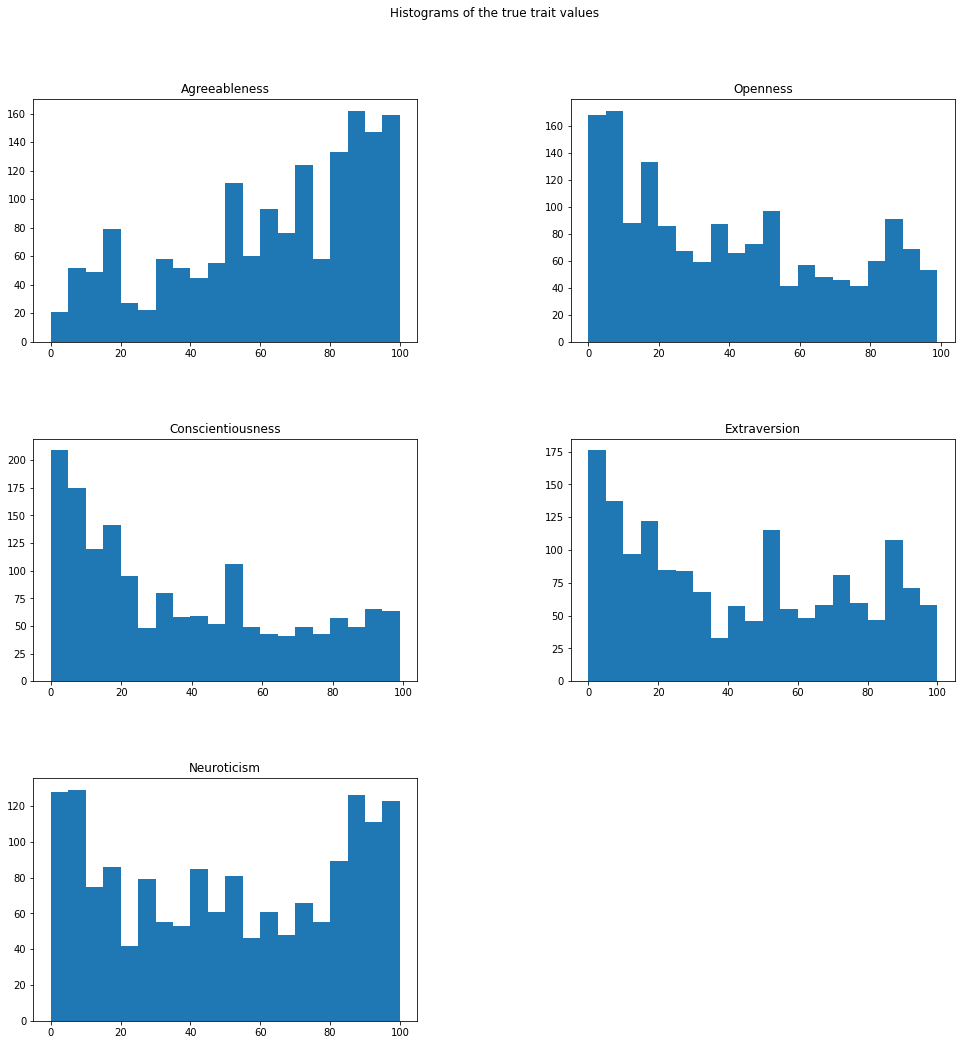

In [29]:
# true histogram plots
all_hist_true(df)